In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import numpy as np
import pytorch_lightning as pl
import torch
from sklearn.manifold import TSNE
from scipy import stats
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

from func2graph import models, data, tools

In [3]:
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'font.size': 18
})

### Simulated Data

In [222]:
trainer = pl.Trainer(
    devices=[1],
    accelerator="gpu",
    benchmark=False,
    profiler="simple",
)

neuron_num = 200
total_time = 30000

window_size = 200
task_type = "prediction"
predict_window_size = 1

data_random_seed = 42
weight_type = "cell_type"
batch_size = 32
data_type = "wuwei"

weight_scale = 0.2  ##########
init_scale = 0.2   ##########
tau = 1             ##########

simulator = data.data_simulator(
    neuron_num=neuron_num, 
    tau=tau,  
    weight_scale=weight_scale,
    init_scale=init_scale,
    total_time=total_time,
    data_random_seed=data_random_seed,
    weight_type=weight_type
)

b = simulator.b

data_result = data.generate_simulation_data(
    neuron_num=neuron_num,
    total_time=30000,
    tau=tau,
    data_random_seed=data_random_seed,
    weight_type=weight_type,
    window_size=window_size,
    batch_size=batch_size,
    task_type=task_type,
    predict_window_size=predict_window_size,
    data_type=data_type,
    weight_scale=weight_scale,
    init_scale=init_scale,
)
trainloader, validloader, weight_matrix, cell_type_ids, cell_type_order, cell_type_count = data_result
# results = trainer.predict(predict_mode_model, dataloaders=[trainloader], ckpt_path=checkpoint_path)

print(cell_type_ids)
print(cell_type_order)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
['EC', 'Pvalb', 'Sst', 'Vip']


In [225]:
checkpoint_path = '../../output/Baselines_neuroAI/AwC_sim2.ckpt'
trained_model = models.Attention_With_Constraint_2_sim.load_from_checkpoint(checkpoint_path)

idx = torch.arange(neuron_num).to(trained_model.device)
neuron_embeddings = trained_model.embedding_table(idx).detach().cpu().numpy()
print(neuron_embeddings.shape)

(200, 200)


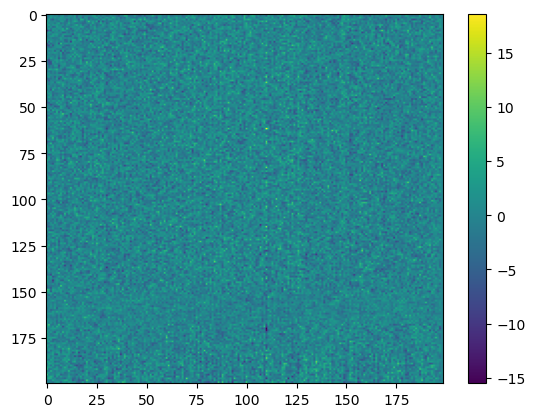

In [171]:
plt.imshow(neuron_embeddings, aspect="auto")
plt.colorbar()
plt.show()

In [226]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(neuron_embeddings)
print(tsne.shape)

(200, 2)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


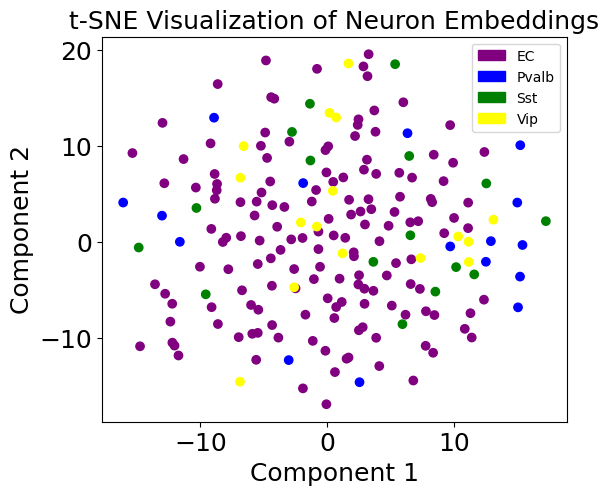

In [227]:
# color by cell type
print(cell_type_ids)

colors = ['purple', 'blue', 'green', 'yellow']
colors_list = [colors[i] for i in cell_type_ids]

plt.figure(figsize=(6, 5))
# create a legend to map cell type to color
plt.scatter(tsne[:, 0], tsne[:, 1], c=colors_list)
purple_patch = mpatches.Patch(color='purple', label='EC')
blue_patch = mpatches.Patch(color='blue', label='Pvalb')
green_patch = mpatches.Patch(color='green', label='Sst')
yellow_patch = mpatches.Patch(color='yellow', label='Vip')
plt.legend(handles=[purple_patch, blue_patch, green_patch, yellow_patch])
plt.title('t-SNE Visualization of Neuron Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

### Binary Classification for Simulation Data

In [228]:
all_X = neuron_embeddings
all_y = np.array(cell_type_ids)

# randomly split the data into train and test
np.random.seed(42)
train_indices = np.random.choice(len(all_y), int(len(all_y) * 0.75), replace=False)
test_indices = np.setdiff1d(np.arange(len(all_y)), train_indices)
X_train = all_X[train_indices]
y_train = all_y[train_indices]
X_test = all_X[test_indices]
y_test = all_y[test_indices]

print('original X_train:', X_train.shape)
print('original X_test:', X_test.shape)

# Make EC and IN balanced in train set
X_train_EC = X_train[y_train==0]
y_train_EC = y_train[y_train==0]
X_train_IN = X_train[y_train!=0]
y_train_IN = y_train[y_train!=0]

X_train_EC = X_train_EC[:len(X_train_IN)]
y_train_EC = y_train_EC[:len(y_train_IN)]

X_train = np.concatenate((X_train_EC, X_train_IN), axis=0)
y_train = np.concatenate((y_train_EC, y_train_IN), axis=0)

# Shuffle the train set
indices = np.arange(len(y_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

print('X_train EC:', X_train_EC.shape)
print('X_train IN:', X_train_IN.shape)
print('X_test EC:', X_test[y_test==0].shape)
print('X_test IN:', X_test[y_test!=0].shape)

# For binary classification, make EC as 0 and IN as 1
y_train[y_train!=0] = 1
y_test[y_test!=0] = 1

original X_train: (150, 200)
original X_test: (50, 200)
X_train EC: (34, 200)
X_train IN: (34, 200)
X_test EC: (36, 200)
X_test IN: (14, 200)


1.0
EC IN proportion in TRAIN [0.5 0.5]
0.9
EC IN proportion in TEST [0.72 0.28]
auroc 0.9781746031746031


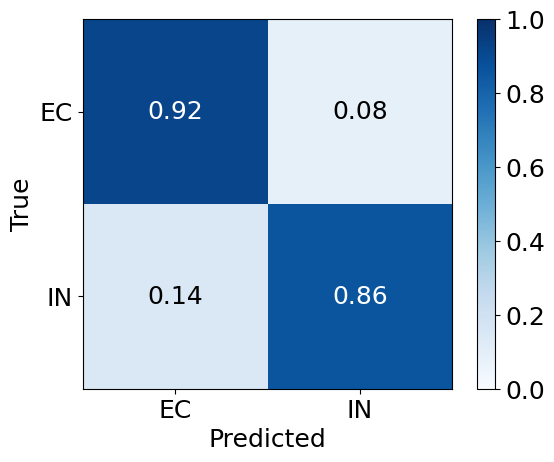

In [231]:
from sklearn.linear_model import LogisticRegression
np.random.seed(42)

clf = LogisticRegression(random_state=42).fit(X_train, y_train)
print(clf.score(X_train, y_train))
print('EC IN proportion in TRAIN', np.unique(y_train, return_counts=True)[1] / len(y_train))

print(clf.score(X_test, y_test))
print('EC IN proportion in TEST', np.unique(y_test, return_counts=True)[1] / len(y_test))

# compute auroc
y_pred = clf.predict_proba(X_test)[:, 1]
print('auroc', roc_auc_score(y_test, y_pred))

# get confusion matrix
y_pred = clf.predict(X_test)
# convert confusion matrix to percentage
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
# label percentage on the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

# label the axes
plt.xticks([0, 1], ['EC', 'IN'])
plt.yticks([0, 1], ['EC', 'IN'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.clim(0, 1)
# make font size larger
plt.show()

### Multiclass Classification for Simulation Data

In [79]:
# remove EC
all_X = all_X[all_y!=cell_type_order.index('EC')]
all_y = all_y[all_y!=cell_type_order.index('EC')]

# Make Pvalb labeled 0, Sst labeled 1, Vip labeled 2
all_y[all_y==cell_type_order.index('Pvalb')] = 0
all_y[all_y==cell_type_order.index('Sst')] = 1
all_y[all_y==cell_type_order.index('Vip')] = 2

print('unique cell type ids', np.unique(all_y))

# randomly split the data into train and test
np.random.seed(42)
train_indices = np.random.choice(len(all_y), int(len(all_y) * 0.75), replace=False)
test_indices = np.setdiff1d(np.arange(len(all_y)), train_indices)
X_train = all_X[train_indices]
y_train = all_y[train_indices]
X_test = all_X[test_indices]
y_test = all_y[test_indices]

print('num neurons in each cell type TRAIN', np.unique(y_train, return_counts=True)[1])
print('num neurons in each cell type TEST', np.unique(y_test, return_counts=True)[1])

# Make all classes balanced in train set
min_len = min(np.unique(y_train, return_counts=True)[1])

X_train_0 = X_train[y_train==0][:min_len]
y_train_0 = y_train[y_train==0][:min_len]
X_train_1 = X_train[y_train==1][:min_len]
y_train_1 = y_train[y_train==1][:min_len]
X_train_2 = X_train[y_train==2][:min_len]
y_train_2 = y_train[y_train==2][:min_len]

X_train = np.concatenate((X_train_0, X_train_1, X_train_2), axis=0)
y_train = np.concatenate((y_train_0, y_train_1, y_train_2), axis=0)

# Shuffle the train set
indices = np.arange(len(y_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

print('num neurons in each cell type TRAIN', np.unique(y_train, return_counts=True)[1])
print('num neurons in each cell type TEST', np.unique(y_test, return_counts=True)[1])


unique cell type ids [0 1 2]
num neurons in each cell type TRAIN [13 11 12]
num neurons in each cell type TEST [3 5 4]
num neurons in each cell type TRAIN [11 11 11]
num neurons in each cell type TEST [3 5 4]


1.0
class proportion in TRAIN [0.33333333 0.33333333 0.33333333]
1.0
class proportion in TEST [0.25       0.41666667 0.33333333]


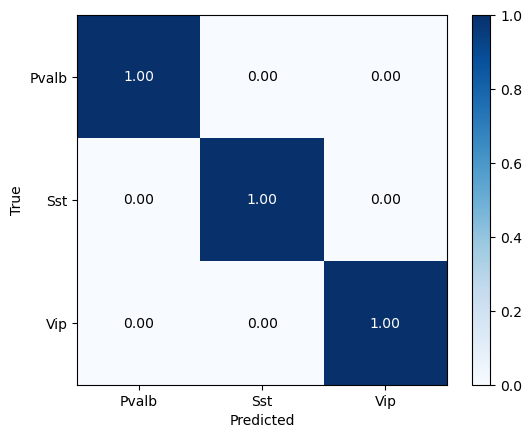

In [188]:
from sklearn.linear_model import LogisticRegression
np.random.seed(42)

# multi-class classification
clf = LogisticRegression(random_state=42, multi_class='multinomial', max_iter=1000).fit(X_train, y_train)
print(clf.score(X_train, y_train))
print('class proportion in TRAIN', np.unique(y_train, return_counts=True)[1] / len(y_train))

print(clf.score(X_test, y_test))
print('class proportion in TEST', np.unique(y_test, return_counts=True)[1] / len(y_test))

# confusion matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

plt.xticks([0, 1, 2], ['Pvalb', 'Sst', 'Vip'])
plt.yticks([0, 1, 2], ['Pvalb', 'Sst', 'Vip'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.clim(0, 1)
plt.show()

### Real Mouse Data

In [5]:
window_size = 60   ##########################
batch_size = 32

train_dataloader, val_dataloader, num_unqiue_neurons, cell_type_order, all_sessions_new_cell_type_id, num_batch_per_session_TRAIN, num_batch_per_session_VAL, sessions_2_original_cell_type, neuron_id_2_cell_type_id = data.generate_mouse_all_sessions_data(
    input_mouse=['SB025'],              ##########################
    input_sessions=[['2019-10-23']],    ####### '2019-10-04', '2019-10-07', '2019-10-08', '2019-10-09', '2019-10-23', '2019-10-24'
    window_size=window_size,
    batch_size=batch_size,
)

checkpoint_path = "../../output/Baselines_neuroAI/AwC_M2_100.ckpt"
trained_model = models.Attention_With_Constraint_2.load_from_checkpoint(checkpoint_path)
trained_model.eval()

indices = torch.tensor([0,1,2]).cuda()
neuron_embeddings = trained_model.embedding_table(indices)
print('neuron_embeddings:', neuron_embeddings.shape)

print('EC:', len(neuron_id_2_cell_type_id[neuron_id_2_cell_type_id==0]))
print('IN:', len(neuron_id_2_cell_type_id[neuron_id_2_cell_type_id!=0]))
print('\n')

for i in range(len(cell_type_order)):
    print(cell_type_order[i], len(neuron_id_2_cell_type_id[neuron_id_2_cell_type_id==i]))

SB025/2019-10-23
no normalization
cell_type_order: ['EC', 'IN', 'Lamp5', 'Pvalb', 'Serpinf1', 'Sncg', 'Sst', 'Vip']
neuron_embeddings: torch.Size([3, 100])
EC: 264
IN: 263


EC 264
IN 98
Lamp5 59
Pvalb 38
Serpinf1 1
Sncg 5
Sst 13
Vip 49


#### E W_Q_W_KT E^T

In [ ]:
indices = torch.arange(num_unqiue_neurons).cuda()
neuron_embeddings = trained_model.embedding_table(indices).cpu().detach().numpy()

W_Q_W_KT = trained_model.attentionlayers[0][0].W_Q_W_KT.weight.cpu().detach().numpy()  # (out_dim, in_dim)
W_Q_W_KT = W_Q_W_KT.T  # (in_dim, out_dim)
print('W_Q_W_KT: ', W_Q_W_KT.shape)

result = neuron_embeddings @ W_Q_W_KT @ neuron_embeddings.T
print(result.shape)

plt.imshow(result, cmap='bone', interpolation='nearest')
plt.colorbar()
plt.show()

result = tools.group_connectivity_matrix_by_cell_type(result, neuron_id_2_cell_type_id)

plt.imshow(result, cmap='bone', interpolation='nearest')
plt.colorbar()
plt.show()

KK_result = tools.multisession_NN_to_KK_1(
    [result], 
    multisession_binary_NN_list=None, 
    cell_type_order=cell_type_order, 
    multisession_cell_type_id_list=[neuron_id_2_cell_type_id]
)

plt.imshow(KK_result, interpolation='nearest')
plt.colorbar()
plt.show()

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
eval_KK_result = tools.experiment_KK_to_eval_KK(KK_result, cell_type_order, eval_cell_type_order)

plt.imshow(eval_KK_result, interpolation='nearest')
plt.colorbar()
plt.show()


-0.5353421890656203
-0.5128973477087254


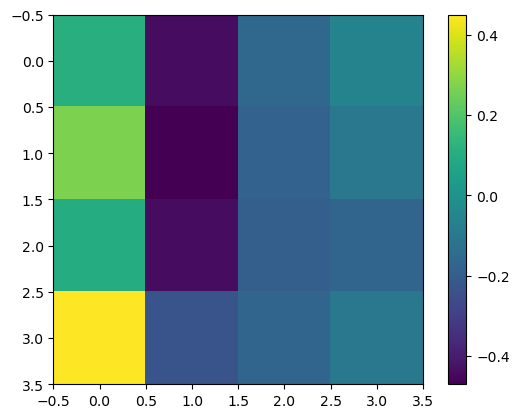

In [5]:
GT_strength_connectivity = np.load("../../data/Mouse_Local_Connectivity/GT_strength_connectivity.npy")

corr_strength_KK = stats.pearsonr(GT_strength_connectivity.flatten(), eval_KK_result.flatten())[0]
spearman_corr_strength_KK = stats.spearmanr(GT_strength_connectivity.flatten(), eval_KK_result.flatten())[0]

print(corr_strength_KK)
print(spearman_corr_strength_KK)

plt.imshow(GT_strength_connectivity, interpolation='nearest')
plt.colorbar()
plt.show()

In [42]:
# create a tensor from 0 to num_unqiue_neurons
indices = torch.arange(num_unqiue_neurons).cuda()
neuron_embeddings = trained_model.embedding_table(indices)
print(neuron_embeddings.shape)

print(neuron_id_2_cell_type_id)
print('unique cell type ids', np.unique(neuron_id_2_cell_type_id))

torch.Size([527, 249])
[2 3 2 3 7 7 2 3 7 3 7 3 3 7 7 7 2 3 2 7 7 3 7 6 2 2 2 2 2 3 3 7 7 7 3 7 2
 2 2 2 7 2 3 3 7 6 5 5 2 2 7 7 7 2 2 2 2 7 3 2 3 7 2 2 2 2 5 3 3 7 7 6 7 2
 7 3 6 3 7 3 2 2 2 2 2 7 6 7 6 7 2 2 7 2 3 3 7 7 3 7 3 2 2 2 7 2 3 3 7 7 3
 5 4 6 2 3 2 3 2 2 7 2 2 7 3 7 3 2 2 2 2 5 3 7 2 6 2 2 6 6 3 7 7 7 2 2 6 3
 2 2 7 3 2 2 3 3 7 2 6 6 7 7 7 7 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0
 0

In [24]:
print(neuron_embeddings.detach().cpu().numpy())

[[ 1.3811752   0.8791364   2.0652244  ...  0.9490798   0.5055173
   0.93369484]
 [-0.47054794 -0.24066733  1.120903   ...  1.1974705  -0.33695883
   0.64369154]
 [-0.66094035  0.6723178  -2.3961697  ... -0.74203485 -0.10051064
  -0.6790276 ]
 ...
 [-0.87132657  1.0057185   0.39441308 ...  0.04751544 -0.691
  -0.33997625]
 [ 1.6864389   0.02831665  0.30119228 ... -0.08975788 -0.80114615
   1.165528  ]
 [ 0.2398049   2.41267     0.8948572  ...  0.08037473 -0.1098464
   0.36099488]]


### Binary Classification

In [6]:
indices = torch.arange(num_unqiue_neurons).cuda()
neuron_embeddings = trained_model.embedding_table(indices)

all_X = neuron_embeddings.detach().cpu().numpy()
all_y = neuron_id_2_cell_type_id.copy()

# remove Sncg and Serpinf1
# all_X = all_X[all_y!=cell_type_order.index('Sncg')]
# all_y = all_y[all_y!=cell_type_order.index('Sncg')]
# all_X = all_X[all_y!=cell_type_order.index('Serpinf1')]
# all_y = all_y[all_y!=cell_type_order.index('Serpinf1')]

# randomly split the data into train and test
np.random.seed(22)    # 100: 22
train_indices = np.random.choice(len(all_y), int(len(all_y) * 0.75), replace=False)
test_indices = np.setdiff1d(np.arange(len(all_y)), train_indices)
X_train = all_X[train_indices]
y_train = all_y[train_indices]
X_test = all_X[test_indices]
y_test = all_y[test_indices]

print('original X_train:', X_train.shape)
print('original X_test:', X_test.shape)

# Make EC and IN balanced in train set
X_train_EC = X_train[y_train==0]
y_train_EC = y_train[y_train==0]
X_train_IN = X_train[y_train!=0]
y_train_IN = y_train[y_train!=0]

X_train_EC = X_train_EC[:len(X_train_IN)]
y_train_EC = y_train_EC[:len(y_train_IN)]

X_train = np.concatenate((X_train_EC, X_train_IN), axis=0)
y_train = np.concatenate((y_train_EC, y_train_IN), axis=0)

# X_test_EC = X_test[y_test==0]
# y_test_EC = y_test[y_test==0]
# X_test_IN = X_test[y_test!=0]
# y_test_IN = y_test[y_test!=0]

# X_test_EC = X_test_EC[:len(X_test_IN)]
# y_test_EC = y_test_EC[:len(y_test_IN)]

# X_test = np.concatenate((X_test_EC, X_test_IN), axis=0)
# y_test = np.concatenate((y_test_EC, y_test_IN), axis=0)

# Shuffle the train set
indices = np.arange(len(y_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

print('X_train EC:', X_train_EC.shape)
print('X_train IN:', X_train_IN.shape)
print('X_test EC:', X_test[y_test==0].shape)
print('X_test IN:', X_test[y_test!=0].shape)

# For binary classification, make EC as 0 and IN as 1
y_train[y_train!=0] = 1
y_test[y_test!=0] = 1

original X_train: (395, 100)
original X_test: (132, 100)
X_train EC: (194, 100)
X_train IN: (201, 100)
X_test EC: (70, 100)
X_test IN: (62, 100)


0.7417721518987341
EC IN proportion in TRAIN [0.49113924 0.50886076]
0.6666666666666666
EC IN proportion in TEST [0.53030303 0.46969697]
auroc 0.6995391705069125


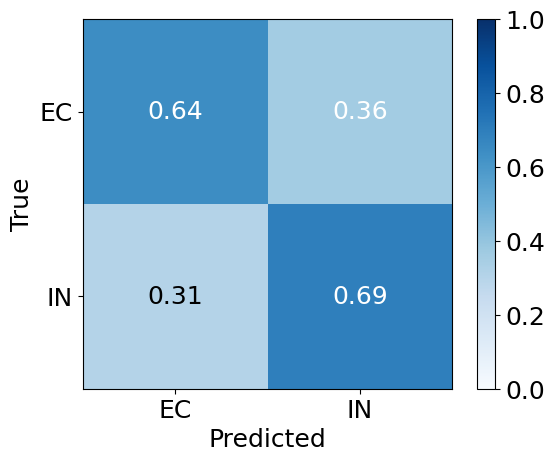

In [7]:
from sklearn.linear_model import LogisticRegression
np.random.seed(42)

clf = LogisticRegression(random_state=42).fit(X_train, y_train)
print(clf.score(X_train, y_train))
print('EC IN proportion in TRAIN', np.unique(y_train, return_counts=True)[1] / len(y_train))

print(clf.score(X_test, y_test))
print('EC IN proportion in TEST', np.unique(y_test, return_counts=True)[1] / len(y_test))

# compute auroc
y_pred = clf.predict_proba(X_test)[:, 1]
print('auroc', roc_auc_score(y_test, y_pred))

# get confusion matrix
y_pred = clf.predict(X_test)
# convert confusion matrix to percentage
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
# label percentage on the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

# label the axes
plt.xticks([0, 1], ['EC', 'IN'])
plt.yticks([0, 1], ['EC', 'IN'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.clim(0, 1)
plt.show()

1.0
class proportion in TRAIN [0.5 0.5]
0.7424242424242424
class proportion in TEST [0.45454545 0.54545455]
auroc 0.757175925925926


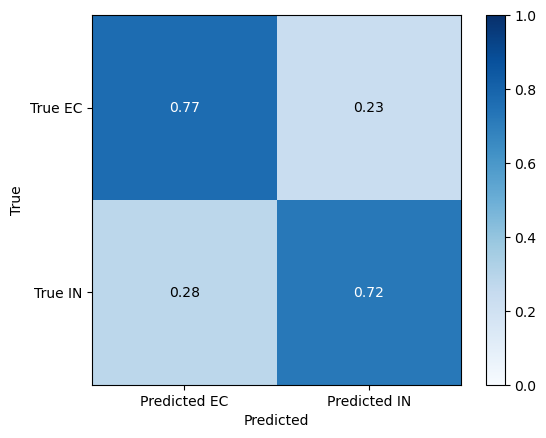

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(32,8), activation='relu', solver='adam', max_iter=5000, random_state=1)
mlp.fit(X_train, y_train)
print(mlp.score(X_train, y_train))
print('class proportion in TRAIN', np.unique(y_train, return_counts=True)[1] / len(y_train))

print(mlp.score(X_test, y_test))
print('class proportion in TEST', np.unique(y_test, return_counts=True)[1] / len(y_test))

# compute auroc
y_pred = mlp.predict_proba(X_test)[:, 1]
print('auroc', roc_auc_score(y_test, y_pred))

# get confusion matrix
y_pred = mlp.predict(X_test)
# convert confusion matrix to percentage
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
# label percentage on the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

# label the axes
plt.xticks([0, 1], ['Predicted EC', 'Predicted IN'])
plt.yticks([0, 1], ['True EC', 'True IN'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.clim(0, 1)
plt.savefig('../../output/2019-10-23_EI_MLP.png')
plt.show()

### Multiclass Classification

In [37]:
indices = torch.arange(num_unqiue_neurons).cuda()
neuron_embeddings = trained_model.embedding_table(indices)

all_X = neuron_embeddings.detach().cpu().numpy()
all_y = neuron_id_2_cell_type_id.copy()

# remove Sncg and Serpinf1, EC, IN, Sst
all_X = all_X[all_y!=cell_type_order.index('Sncg')]
all_y = all_y[all_y!=cell_type_order.index('Sncg')]
all_X = all_X[all_y!=cell_type_order.index('Serpinf1')]
all_y = all_y[all_y!=cell_type_order.index('Serpinf1')]
all_X = all_X[all_y!=cell_type_order.index('EC')]
all_y = all_y[all_y!=cell_type_order.index('EC')]
all_X = all_X[all_y!=cell_type_order.index('IN')]
all_y = all_y[all_y!=cell_type_order.index('IN')]
all_X = all_X[all_y!=cell_type_order.index('Sst')]
all_y = all_y[all_y!=cell_type_order.index('Sst')]

# Make Lamp5 labeled 0, Pvalb labeled 1, Sst labeled 2, Vip labeled 3
all_y[all_y==cell_type_order.index('Lamp5')] = 0
all_y[all_y==cell_type_order.index('Pvalb')] = 1
# all_y[all_y==cell_type_order.index('Sst')] = 2
all_y[all_y==cell_type_order.index('Vip')] = 2

print('unique cell type ids', np.unique(all_y))

# randomly split the data into train and test
np.random.seed(42)
train_indices = np.random.choice(len(all_y), int(len(all_y) * 0.7), replace=False)
test_indices = np.setdiff1d(np.arange(len(all_y)), train_indices)
X_train = all_X[train_indices]
y_train = all_y[train_indices]
X_test = all_X[test_indices]
y_test = all_y[test_indices]

print('num neurons in each cell type TRAIN', np.unique(y_train, return_counts=True)[1])
print('num neurons in each cell type TEST', np.unique(y_test, return_counts=True)[1])

# Make all classes balanced in train set
min_len = min(np.unique(y_train, return_counts=True)[1])

X_train_0 = X_train[y_train==0][:min_len]
y_train_0 = y_train[y_train==0][:min_len]
X_train_1 = X_train[y_train==1][:min_len]
y_train_1 = y_train[y_train==1][:min_len]
X_train_2 = X_train[y_train==2][:min_len]
y_train_2 = y_train[y_train==2][:min_len]
# X_train_3 = X_train[y_train==3][:min_len]
# y_train_3 = y_train[y_train==3][:min_len]

X_train = np.concatenate((X_train_0, X_train_1, X_train_2), axis=0)
y_train = np.concatenate((y_train_0, y_train_1, y_train_2), axis=0)

# Shuffle the train set
indices = np.arange(len(y_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

print('num neurons in each cell type TRAIN', np.unique(y_train, return_counts=True)[1])
print('num neurons in each cell type TEST', np.unique(y_test, return_counts=True)[1])


unique cell type ids [0 1 2]
num neurons in each cell type TRAIN [40 29 33]
num neurons in each cell type TEST [19  9 16]
num neurons in each cell type TRAIN [29 29 29]
num neurons in each cell type TEST [19  9 16]


1.0
class proportion in TRAIN [0.33333333 0.33333333 0.33333333]
0.36363636363636365
class proportion in TEST [0.43181818 0.20454545 0.36363636]


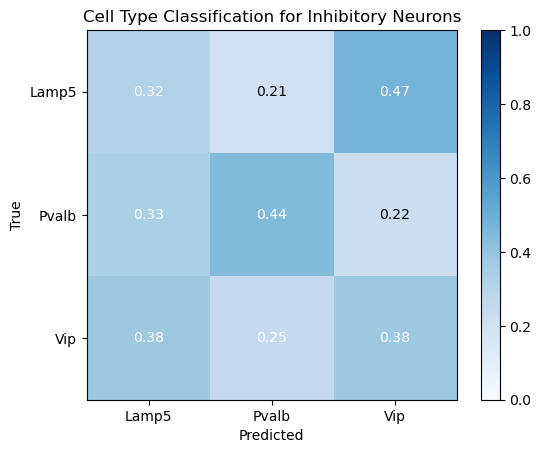

In [38]:
from sklearn.linear_model import LogisticRegression
np.random.seed(42)

# multi-class classification
clf = LogisticRegression(random_state=42, multi_class='multinomial', max_iter=1000).fit(X_train, y_train)
print(clf.score(X_train, y_train))
print('class proportion in TRAIN', np.unique(y_train, return_counts=True)[1] / len(y_train))

print(clf.score(X_test, y_test))
print('class proportion in TEST', np.unique(y_test, return_counts=True)[1] / len(y_test))

# confusion matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

plt.xticks([0, 1, 2], ['Lamp5', 'Pvalb', 'Vip'])
plt.yticks([0, 1, 2], ['Lamp5', 'Pvalb', 'Vip'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Cell Type Classification for Inhibitory Neurons')
plt.clim(0, 1)
plt.show()


1.0
class proportion in TRAIN [0.33333333 0.33333333 0.33333333]
0.4090909090909091
class proportion in TEST [0.43181818 0.20454545 0.36363636]


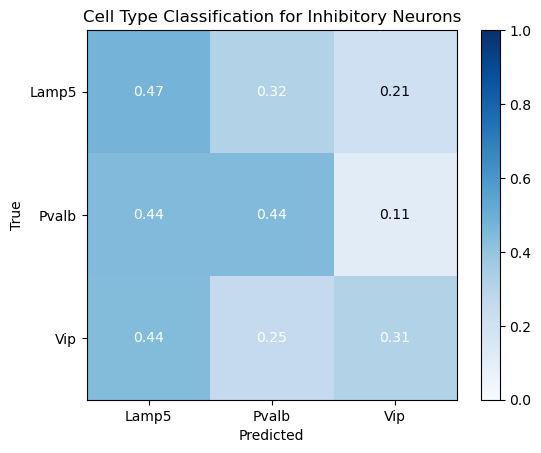

In [39]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(8,64,8), activation='relu', solver='adam', max_iter=1000, random_state=1)
mlp.fit(X_train, y_train)
print(mlp.score(X_train, y_train))
print('class proportion in TRAIN', np.unique(y_train, return_counts=True)[1] / len(y_train))

print(mlp.score(X_test, y_test))
print('class proportion in TEST', np.unique(y_test, return_counts=True)[1] / len(y_test))

# confusion matrix
y_pred = mlp.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

plt.xticks([0, 1, 2], ['Lamp5', 'Pvalb', 'Vip'])
plt.yticks([0, 1, 2], ['Lamp5', 'Pvalb', 'Vip'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Cell Type Classification for Inhibitory Neurons')
plt.clim(0, 1)
plt.show()


(1484, 2)


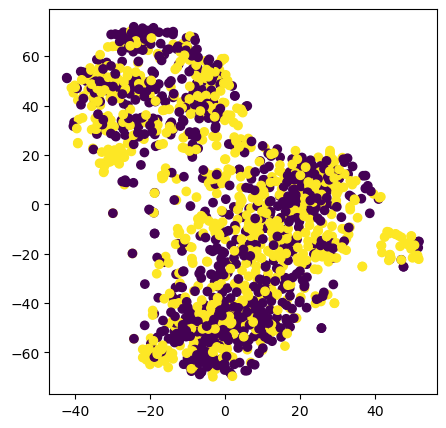

In [24]:
# TSNE

tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15, method='exact').fit_transform(X_train)
print(tsne.shape)

plt.figure(figsize=(5, 5))
plt.scatter(tsne[:, 0], tsne[:, 1], c=y_train)
plt.show()

In [62]:
# KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(tsne[train_indices], y_train)
y_pred = knn.predict(tsne[test_indices])
print(accuracy_score(y_test, y_pred))

0.5216049382716049
